Try training on GHZ state using data in random bases

In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor
from utils import build_ghz_plus

Pick system size, dimensionality of local hilbert space, and initial bond dim

In [3]:
L=4
local_dim=2
bond_dim=2

Initialize the MPS model

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

The ground truth state (a ghz state with no phase)

In [5]:
ghz_plus = build_ghz_plus(L)

Samples_tr: lists indices of the observed basis states at each measurement. 0 = spin up, 1 = spin down

settings: array of corresponding angles

In [7]:
fname_settings = "test_datasets/settings_ghz_plus_random_basis_L=%d.npy"%L
fname_samples = "test_datasets/samples_ghz_plus_random_basis_L=%d.npy"%L
samples = np.load(fname_samples)
samples_tr = torch.tensor((1-samples)/2).to(torch.long)
settings = np.load(fname_settings)

In [8]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [9]:
from qtools import pauli_exp

Holds the unitaries corresponding to each angle

In [10]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [11]:
from torch.utils.data import TensorDataset, DataLoader

In [12]:
from utils import MeasurementDataset,do_local_sgd_training

A dataset which yields outcomes and corresponding rotations

In [13]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

Batch size and learning rate for training:

In [14]:
batch_size = 256
lr = 1e-2

In [15]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

Number of epochs of training

In [16]:
epochs = 5

How many grad-descent steps to perform at each bond

In [17]:
nstep=1

Max number of singular values to keep, and cutoff below which to truncate singular values

In [18]:
max_sv = None
cutoff=1e-8

Regularization term: penalty for Renyi-2 entropy, here set to zero

In [19]:
s2_schedule = np.concatenate([np.linspace(.0, 0, (epochs-1) * len(dl)), np.zeros(len(dl))])

In [20]:
logdict = do_local_sgd_training(psi,dl,epochs=epochs,learning_rate=lr,
                         s2_schedule=s2_schedule,nstep=nstep,cutoff=cutoff,max_sv_to_keep=max_sv,
                         ground_truth_mps=ghz_plus, verbose=True)

In [21]:
fidelity = logdict['fidelity']
losses = logdict['loss']

In [31]:
import time

In [22]:
import matplotlib.pyplot as plt

In [23]:
import datetime

In [24]:
t = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

Text(0.5,1,'batch NLL loss 2019-05-02_09:00:05')

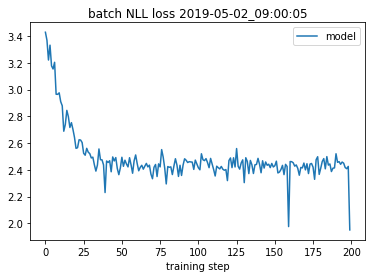

In [25]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(losses, label='model')
plt.legend()
plt.xlabel("training step")
plt.title("batch NLL loss %s" % t)
# fig.savefig("assets/nll_loss_example_{0}.png".format(t))

Text(0.5,1,'fidelity')

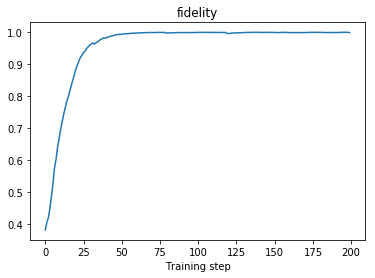

In [26]:
plt.plot(fidelity)
plt.xlabel("Training step")
plt.title("fidelity")

In [27]:
from tools import generate_binary_space

In [28]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [29]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1, 1, 1]) has probability 0.0001
tensor([1, 1, 1, 0]) has probability 0.0000
tensor([1, 1, 0, 1]) has probability 0.0002
tensor([1, 1, 0, 0]) has probability 0.0002
tensor([1, 0, 1, 1]) has probability 0.0001
tensor([1, 0, 1, 0]) has probability 0.4764
tensor([1, 0, 0, 1]) has probability 0.0000
tensor([1, 0, 0, 0]) has probability 0.0001
tensor([0, 1, 1, 1]) has probability 0.0001
tensor([0, 1, 1, 0]) has probability 0.0001
tensor([0, 1, 0, 1]) has probability 0.5203
tensor([0, 1, 0, 0]) has probability 0.0002
tensor([0, 0, 1, 1]) has probability 0.0009
tensor([0, 0, 1, 0]) has probability 0.0004
tensor([0, 0, 0, 1]) has probability 0.0004
tensor([0, 0, 0, 0]) has probability 0.0003


In [30]:
with torch.no_grad():
    for i in range(len(basis)):
        a = psi.amplitude_normalized(basis[i])
        atrue = ghz_plus.amplitude_normalized(basis[i])
        print("{0} has amplitude {1:.4f} (target: {2:.4f})".format(basis[i], a.numpy().item(),
                                                                         atrue.numpy().item()))

tensor([1, 1, 1, 1]) has amplitude -0.0062+0.0052j (target: 0.0000+0.0000j)
tensor([1, 1, 1, 0]) has amplitude -0.0020-0.0067j (target: 0.0000+0.0000j)
tensor([1, 1, 0, 1]) has amplitude 0.0084-0.0133j (target: 0.0000+0.0000j)
tensor([1, 1, 0, 0]) has amplitude -0.0141+0.0061j (target: 0.0000+0.0000j)
tensor([1, 0, 1, 1]) has amplitude 0.0080+0.0058j (target: 0.0000+0.0000j)
tensor([1, 0, 1, 0]) has amplitude 0.4624+0.5124j (target: 0.7071+0.0000j)
tensor([1, 0, 0, 1]) has amplitude -0.0039-0.0034j (target: 0.0000+0.0000j)
tensor([1, 0, 0, 0]) has amplitude 0.0065+0.0071j (target: 0.0000+0.0000j)
tensor([0, 1, 1, 1]) has amplitude -0.0098+0.0026j (target: 0.0000+0.0000j)
tensor([0, 1, 1, 0]) has amplitude 0.0081+0.0089j (target: 0.0000+0.0000j)
tensor([0, 1, 0, 1]) has amplitude 0.4986+0.5212j (target: 0.7071+0.0000j)
tensor([0, 1, 0, 0]) has amplitude -0.0091-0.0118j (target: 0.0000+0.0000j)
tensor([0, 0, 1, 1]) has amplitude -0.0231-0.0181j (target: 0.0000+0.0000j)
tensor([0, 0, 1, 0